In [376]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

In [373]:
pd.set_option('display.width', 1000)

In [486]:
data = "JH"

In [487]:
if data == "JH":
    url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

    df_load_cases = pd\
        .read_csv(url_cases, sep=',', engine='python')\
        .groupby("Country/Region")\
        .sum()\
        .reset_index(level=[0])\
        .rename({"Country/Region": 'countriesAndTerritories'}, axis='columns', inplace=False)\
        .drop(['Lat', 'Long'], axis='columns')\
        .melt('countriesAndTerritories', var_name='dateRep', value_name='cum_cases')

    url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

    df_load_deaths = pd\
        .read_csv(url_deaths, sep=',', engine='python')\
        .groupby("Country/Region")\
        .sum()\
        .reset_index(level=[0])\
        .rename({"Country/Region": 'countriesAndTerritories'}, axis='columns', inplace=False)\
        .drop(['Lat', 'Long'], axis='columns')\
        .melt('countriesAndTerritories', var_name='dateRep', value_name='cum_deaths')

    df_load = pd\
        .merge(df_load_cases, df_load_deaths,  how='inner', on=['countriesAndTerritories', 'dateRep'])

    df_load['dateRep'] = df_load['dateRep'].map(lambda x : (datetime.strptime(x, '%m/%d/%y').strftime('%d/%m/%Y')))

    df_1 = df_load

    df_1['days'] = df_1['dateRep']\
        .map(lambda x : (datetime.strptime(x, '%d/%m/%Y') - datetime.strptime("01/01/2020", '%d/%m/%Y')).days)

    df_1 = df_1.sort_values(['countriesAndTerritories', 'days'], ascending=[True, True])
    df_1 = df_1[df_1['days'] >= 0]

    df_2 = df_1\
        .loc[:,['countriesAndTerritories', 'days', 'dateRep', 'cum_cases', 'cum_deaths']]

Remarks: ECDC data does not match RKI data in all time points!

In [488]:
if data == "ECDC":
    url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/"

    df_load = pd\
        .read_csv(url, sep=',', engine='python')

    df_1 = df_load\
        .loc[:,['dateRep','cases', 'deaths', 'countriesAndTerritories']]

    df_1['days'] = df_1['dateRep']\
        .map(lambda x : (datetime.strptime(x, '%d/%m/%Y') - datetime.strptime("01/01/2020", '%d/%m/%Y')).days)

    df_1 = df_1.sort_values(['countriesAndTerritories', 'days'], ascending=[True, True])
    df_1 = df_1[df_1['days'] >= 0]

    df_2 =  df_1\
        .groupby(['countriesAndTerritories', 'days','dateRep'])\
        .agg(cum_cases=('cases', 'sum'), cum_deaths=('deaths', 'sum'))\
        .groupby(level=[0])\
        .cumsum()\
        .reset_index(level=[0, 1, 2])

    df_2 = df_2.sort_values(['countriesAndTerritories', 'days'], ascending=[True, True])

In [489]:
# df_2[(df_2['countriesAndTerritories'] == "Germany") & (df_2['days'] > 70)]

In [490]:
df_same_1 = df_2

df_same_2 = df_same_1[df_same['cum_cases'] >= 1000]\
    .groupby(['countriesAndTerritories'])\
    .agg(min_days=('days', 'min'))

df_3 = pd\
    .merge(df_2, df_same_2,  how='inner', on=['countriesAndTerritories'])

df_3['same_day'] = df_3['days'] - df_3['min_days']

df_3 = df_3.drop(['min_days'], axis='columns')

In [491]:
df_final = df_3

In [492]:
df_countries = df_final\
    .groupby(['countriesAndTerritories'])\
    .agg(cum_cases=('cum_cases', 'max'))\
    .sort_values(['cum_cases'], ascending=[False])\
    .reset_index(level=[0])

list_countries = df_countries.iloc[:9]['countriesAndTerritories'].tolist()

In [493]:
def plot_total(df, country, ax, quantity_axis='cum_cases', days_axis='days', limit=None):
    df = df[df['countriesAndTerritories'] == country]
    df = df[df[quantity_axis] > 0]
    df = df[df[days_axis] > 0]
    
    if limit != None:
        df = df[df[days_axis] < limit]
    
    df.plot(x=days_axis, y=quantity_axis, ax=ax, label=country, alpha=0.5)

In [494]:
# fig, axs = plt.subplots(1, 1)
# for country in list_countries:
#     plot_total(df_final, country, axs)

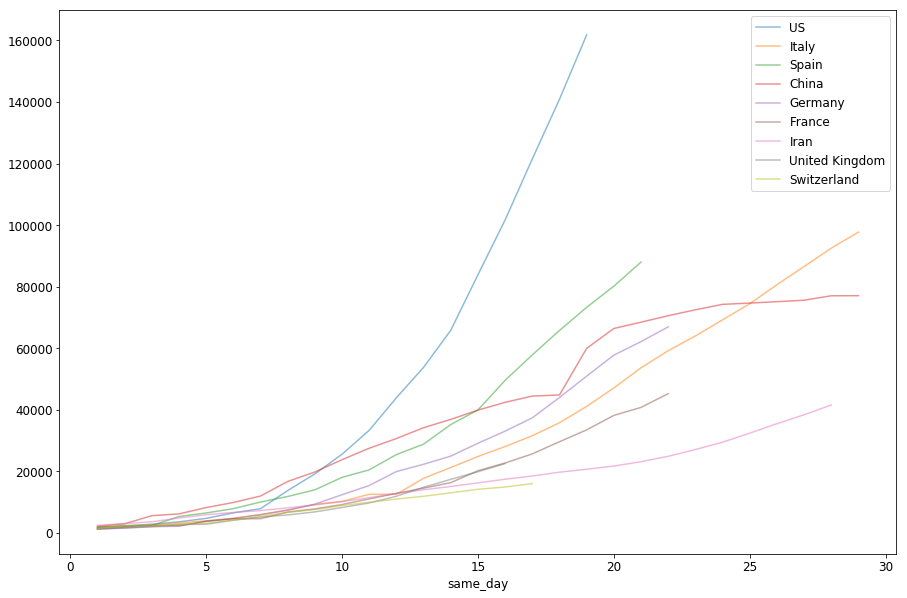

In [495]:
fig, axs = plt.subplots(1, 1)
for country in list_countries:
    plot_total(df_final, country, axs, 'cum_cases', 'same_day', 30)

In [496]:
# fig, axs = plt.subplots(1, 1)
# for country in list_countries:
#     plot_total(df_final, country, axs, 'cum_deaths', 'same_day')

In [497]:
def plot_country(df, country, ax):
    df = df[df['countriesAndTerritories'] == country]
    df = df[df['cum_cases'] > 100]
    
    x = list(df['days'])
    y_cases = list(df['cum_cases'])
    y_deaths = list(df['cum_deaths'])
       
    ax.plot(x, y_cases, label="cases", color="steelblue")
    ax.plot(x, y_deaths, label="deaths", color="orange")
    ax.set_title(country)
    
    ax.fill_between(x, y_deaths, y_cases, alpha=0.5, color="steelblue")
    ax.fill_between(x, 0, y_deaths, alpha=0.5, color="orange")
    
    ax.set_xlabel("Days since 1 January 2020")
    ax.set_ylabel("Cumulated numbers")

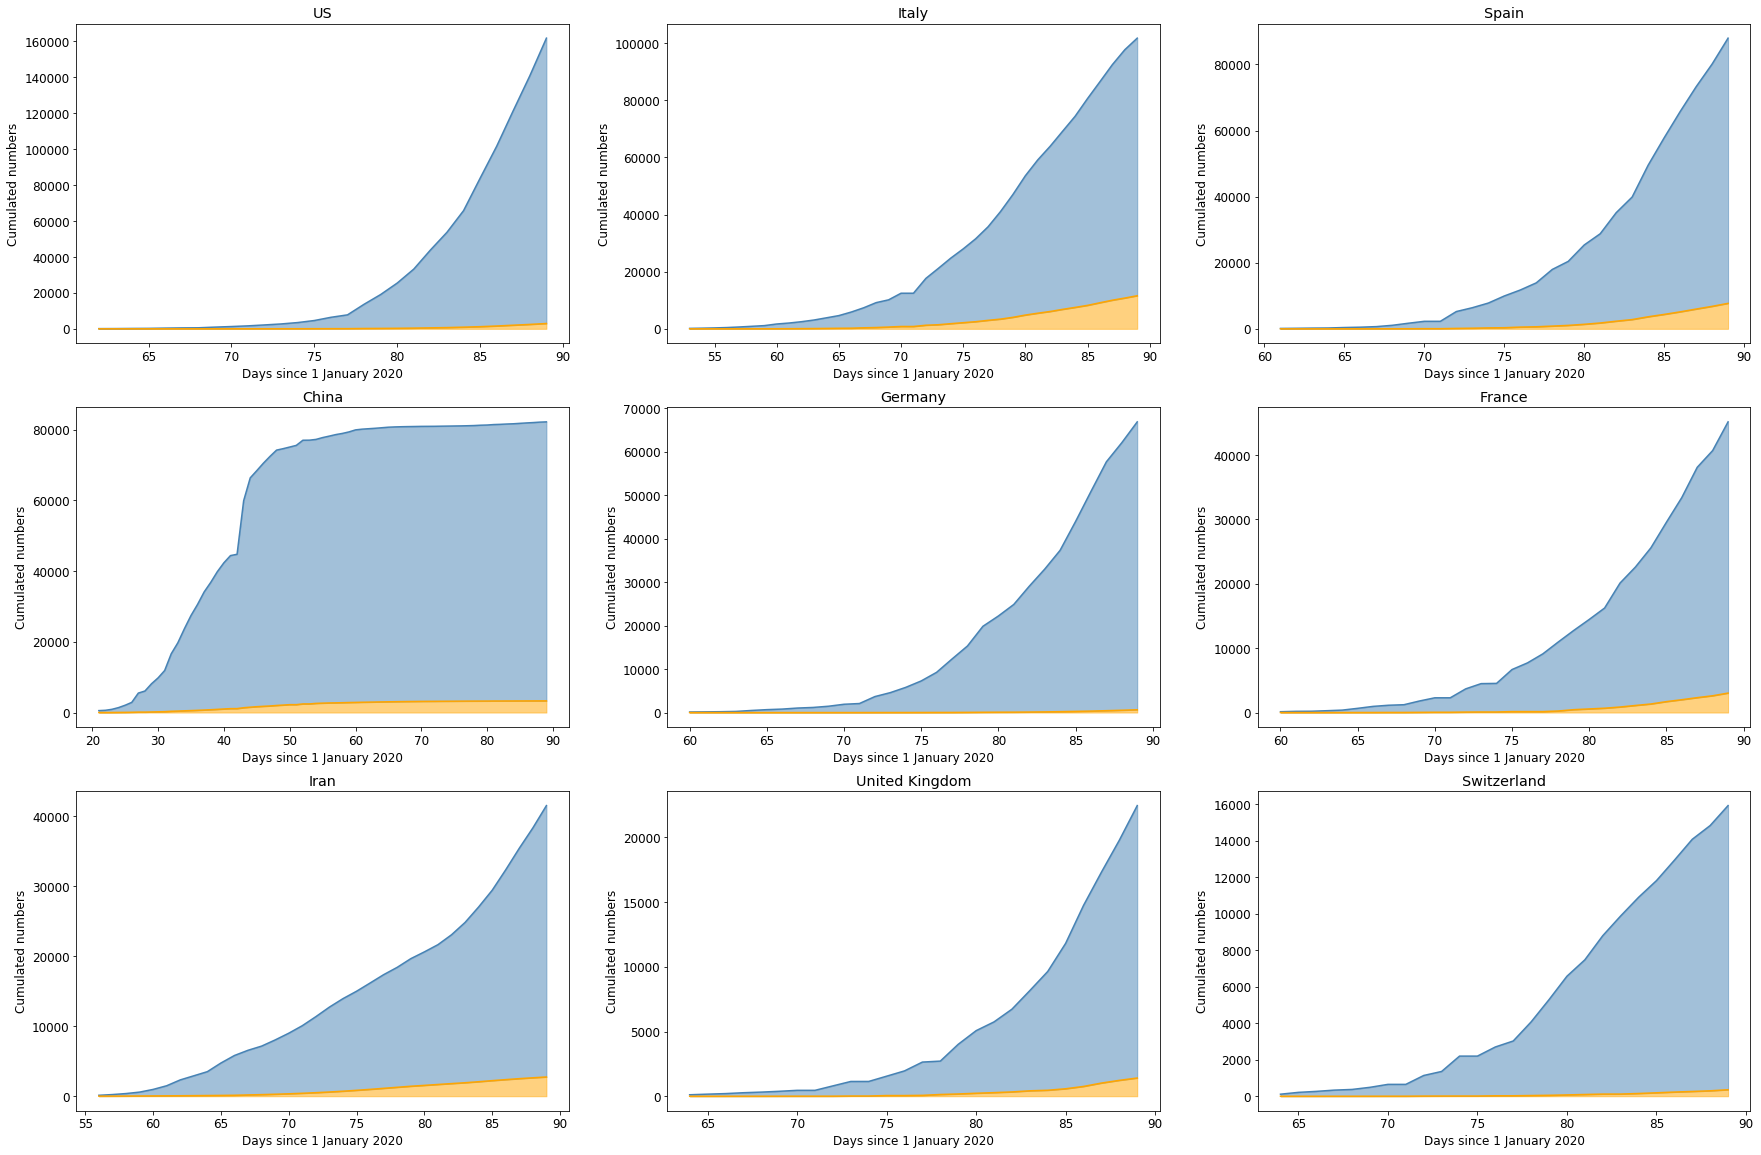

In [498]:
fig, axs = plt.subplots(3, 3, figsize=(30,20))
for country, ax in zip(list_countries, axs.ravel()):
    plot_country(df_final, country, ax)

In [499]:
def logistic_model(x, a, b, c):
    return c/(1 + np.exp(-(x - b)/a))

def exponential_2p_model(x, a, b):
    return a*np.exp(b*x)

def fitting(model, x, y):
    if model == 'logistic':
        fit = curve_fit(logistic_model, x, y, p0=[2, 100, 20000], maxfev = 50000)
        return fit
    if model == 'exponential':
        fit = curve_fit(exponential_2p_model, x, y, p0=[10000, 0.1], maxfev = 50000)
        return fit

def model_selection(model):
    if model == 'logistic':
        return logistic_model
    if model == 'exponential':
        return exponential_2p_model
    
def additiona_info(model, fit):
    if model == 'logistic':
        print('days to reach limit of ', "{:,}".format(int(fit[0][2])) , ': ', "{:,}".format(int(int(fsolve(lambda x : logistic_model(x, *fit[0]) - int(fit[0][2]), fit[0][1])))))
    if model == 'exponential':
        print('time to double:', np.round(np.log(2)/fit[0][1], 1))

In [500]:
def extrapolate(x, y_cases, model, days_fitting, days_extropolate, shift, plot_actuals, plot_curve, ann_pos, ann, cum):

    x_fit = x[-days_fitting - shift:-shift or None]
    y_cases_fit = y_cases[-days_fitting - shift:-shift or None]
    
    if cum:
        if plot_actuals:
            plt.scatter(x_fit, y_cases_fit, label="real data", color="red")
    else:
        if plot_actuals:
            plt.scatter(x_fit[1:], np.diff(y_cases_fit).tolist(), label="real data", color="red")

    selected_model = model_selection(model)
    fit = fitting(model, x_fit, y_cases_fit)

    x_pred = list(range(max(x_fit) + 1, max(x_fit) + days_extropolate + shift + 1))
    y_pred = [int(selected_model(i, *fit[0])) for i in x_pred]
    
    if cum:
        x_pred_plot = x_pred
        y_pred_plot = y_pred
    else:
        x_pred_plot = x_pred[1:]
        y_pred_plot = np.diff(y_pred).tolist()
        
    plt.scatter(x_pred_plot, y_pred_plot, color="gold")
    
    if ann:
        for i,j in zip(x_pred_plot, y_pred_plot):
            plt.annotate("{:,}".format(int(j)), xy=(i, j), horizontalalignment=ann_pos, verticalalignment='top')

    if plot_curve:
        x_tot = x_fit + x_pred
        y_tot = [selected_model(i, *fit[0]) for i in x_tot]
        
        if not cum:
            x_tot = x_tot[1:]
            y_tot = np.diff(y_tot).tolist()
        
        plt.plot(x_tot, y_tot, label=model + " " + str(shift) + " days prior last acutal", color="steelblue", linestyle='dashed')
    
    return x_pred, y_pred, fit

In [501]:
def collect_dict(x_data, y_data):
    
    dict_data = {}

    for x_i, y_i in zip(x_data, y_data):
        dict_data[
            (datetime.strptime("01/01/2020", '%d/%m/%Y') + timedelta(days=x_i)).strftime('%d/%m/%Y')
        ] = "{:,}".format(int(y_i))

    return dict_data

In [502]:
def single_country(model, country, df_input, days_fitting=14, days_extropolate=3, cum=True):
    df_select = df_input[df_input['countriesAndTerritories'] == country]
    df_select  = df_select[df_select['cum_cases'] > 100]
    
    x = list(df_select['days'])
    y_cases = list(df_select['cum_cases'])
    y_deaths = list(df_select['cum_deaths'])

    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams["font.size"] = 12

    ax = plt.axes()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    if cum:
        plt.plot(x, y_cases, label="cases", color="steelblue")
        plt.plot(x, y_deaths, label="deaths", color="orange")
        plt.title(country + " - " + model.capitalize())

        plt.fill_between(x, y_deaths, y_cases, alpha=0.5, color="steelblue")
        plt.fill_between(x, 0, y_deaths, alpha=0.5, color="orange")

        plt.xlabel("Days since 1 January 2020")
        plt.ylabel("Cumulated numbers")
    else:
        plt.plot(x[1:], np.diff(y_cases).tolist(), label="cases", color="steelblue")
        plt.plot(x[1:], np.diff(y_deaths).tolist(), label="deaths", color="orange")
        plt.title(country + " - " + model.capitalize())

        plt.xlabel("Days since 1 January 2020")
        plt.ylabel("Incremental numbers")

    x_pred, y_pred, fit_pred = extrapolate(
        x,
        y_cases,
        model,
        days_fitting=days_fitting,
        days_extropolate=days_extropolate,
        shift=0,
        plot_actuals=True,
        plot_curve=True,
        ann_pos='left',
        ann=False,
        cum=cum
    )

    x_pred_prior, y_pred_prior, fit_pred_prior = extrapolate(
        x,
        y_cases,
        model,
        days_fitting=days_fitting,
        days_extropolate=days_extropolate,
        shift=7,
        plot_actuals=False,
        plot_curve=True,
        ann_pos='right',
        ann=False,
        cum=cum
    )
    
    print('Predic:')
    additiona_info(model, fit_pred)
    print(collect_dict(x[-3:] + x_pred[-2:], y_cases[-3:] + y_pred[-2:]))
    print('Predic Prior:')
    additiona_info(model, fit_pred_prior)
    print(collect_dict(x_pred_prior[-5:], y_pred_prior[-5:]))

    plt.legend()
    plt.show()

In [503]:
print(*[(i, country) for i, country in enumerate(list_countries)], sep='\n')

(0, 'US')
(1, 'Italy')
(2, 'Spain')
(3, 'China')
(4, 'Germany')
(5, 'France')
(6, 'Iran')
(7, 'United Kingdom')
(8, 'Switzerland')


    dateRep  cum_cases  cum_deaths
 17/03/2020       9257          24
 18/03/2020      12327          28
 19/03/2020      15320          44
 20/03/2020      19848          67
 21/03/2020      22213          84
 22/03/2020      24873          94
 23/03/2020      29056         123
 24/03/2020      32986         157
 25/03/2020      37323         206
 26/03/2020      43938         267
 27/03/2020      50871         342
 28/03/2020      57695         433
 29/03/2020      62095         533
 30/03/2020      66885         645

Predic:
days to reach limit of  117,138 :  147
{'28/03/2020': '57,695', '29/03/2020': '62,095', '30/03/2020': '66,885', '01/04/2020': '78,850', '02/04/2020': '83,878'}
Predic Prior:
days to reach limit of  42,604 :  115
{'29/03/2020': '39,861', '30/03/2020': '40,584', '31/03/2020': '41,123', '01/04/2020': '41,522', '02/04/2020': '41,816'}


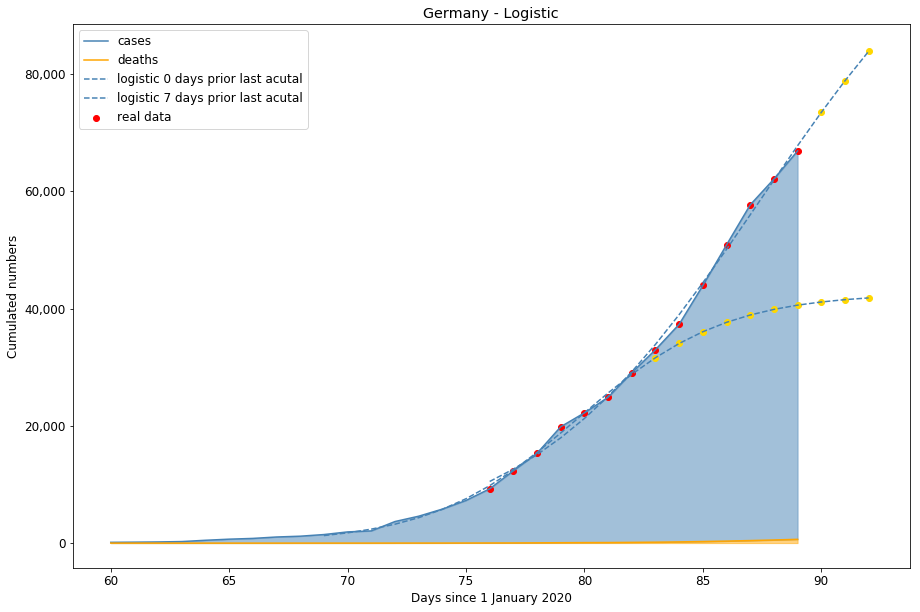

Predic:
time to double: 5.3
{'28/03/2020': '57,695', '29/03/2020': '62,095', '30/03/2020': '66,885', '01/04/2020': '92,212', '02/04/2020': '105,053'}
Predic Prior:
time to double: 3.6
{'29/03/2020': '99,245', '30/03/2020': '120,594', '31/03/2020': '146,536', '01/04/2020': '178,058', '02/04/2020': '216,361'}


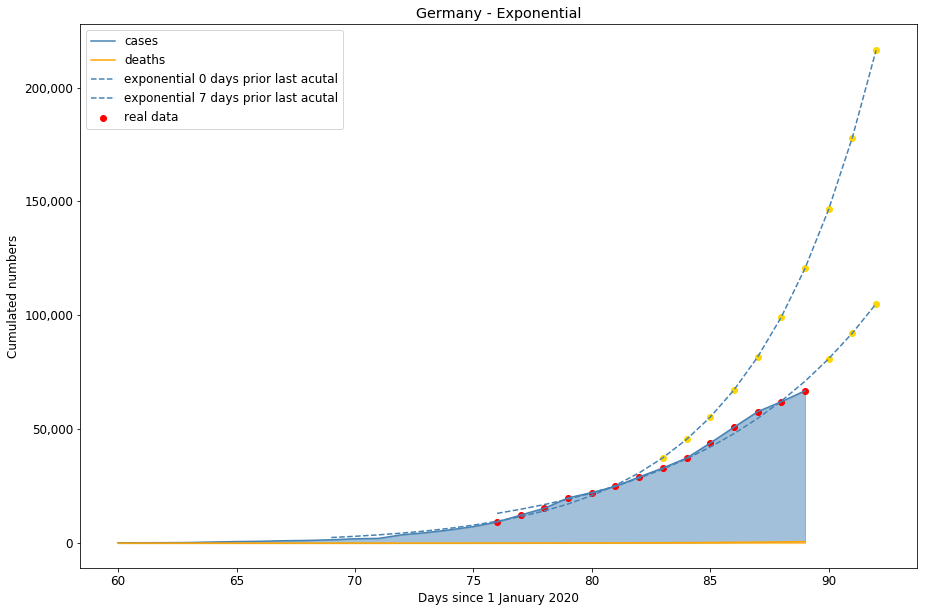

In [504]:
country = list_countries[4]
days_fitting = 14
days_extropolate = 3

df_select = df_final[df_final['countriesAndTerritories'] == country]
df_select  = df_select[df_select['cum_cases'] > 100]

print(df_select.loc[:, ['dateRep', 'cum_cases', 'cum_deaths']][-14:].to_string(index=False))
print('')
    
cum = True

single_country(
    model='logistic',
    country=country,
    df_input=df_final,
    days_fitting=days_fitting,
    days_extropolate=days_extropolate,
    cum=cum
)

single_country(
    model='exponential',
    country=country,
    df_input=df_final,
    days_fitting=days_fitting,
    days_extropolate=days_extropolate,
    cum=cum
)

Predic:
days to reach limit of  117,138 :  147
{'28/03/2020': '57,695', '29/03/2020': '62,095', '30/03/2020': '66,885', '01/04/2020': '78,850', '02/04/2020': '83,878'}
Predic Prior:
days to reach limit of  42,604 :  115
{'29/03/2020': '39,861', '30/03/2020': '40,584', '31/03/2020': '41,123', '01/04/2020': '41,522', '02/04/2020': '41,816'}


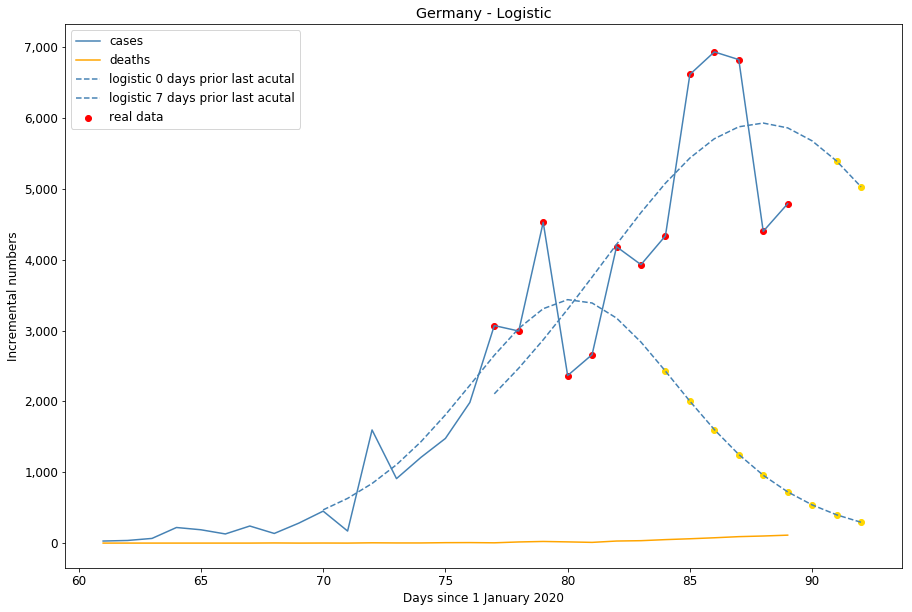

Predic:
time to double: 5.3
{'28/03/2020': '57,695', '29/03/2020': '62,095', '30/03/2020': '66,885', '01/04/2020': '92,212', '02/04/2020': '105,053'}
Predic Prior:
time to double: 3.6
{'29/03/2020': '99,245', '30/03/2020': '120,594', '31/03/2020': '146,536', '01/04/2020': '178,058', '02/04/2020': '216,361'}


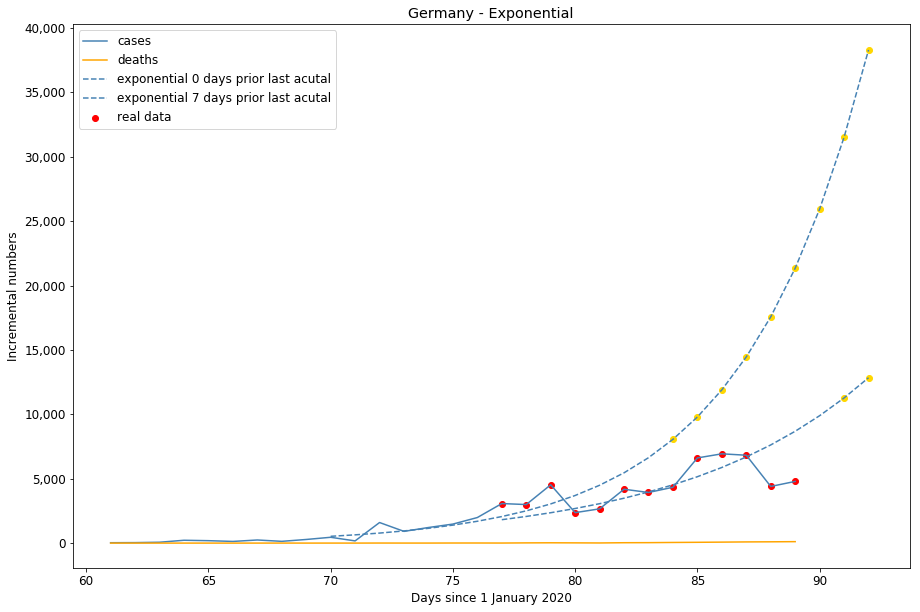

In [505]:
cum = False

single_country(
    model='logistic',
    country=country,
    df_input=df_final,
    days_fitting=days_fitting,
    days_extropolate=days_extropolate,
    cum=cum
)

single_country(
    model='exponential',
    country=country,
    df_input=df_final,
    days_fitting=days_fitting,
    days_extropolate=days_extropolate,
    cum=cum
)